In [1]:
import nltk
from textblob import TextBlob as tb
import math
import io
from __future__ import division
import numpy
import pandas as pd
import matplotlib
import nltk
import re
import os
import string
import codecs
from sklearn import feature_extraction
import mpld3
%matplotlib inline 

from sklearn.feature_extraction.text import TfidfVectorizer

os.chdir('/users/asheets/Documents/Work_Computer_new/Work_Computer/Grad_School/PREDICT_453/Notebooks/DSI/')

all_docs = []
dsis = []
d = 1

cachedStopWords = nltk.corpus.stopwords.words('english')
pattern = re.compile(r'\b(' + r'|'.join(cachedStopWords) + r')\b\s*')

for i in range(40):
    doc_name = 'DSI' + str(d) + '.txt'
    try:
        with open(doc_name, 'r') as f:
            sample = f.read()
        sample = sample.decode('utf-8')
       #sample = sample.decode('ascii')
        sample = sample.lower()
        sample = re.sub(r'[^\w]', ' ', sample)
        sample = ''.join([i for i in sample if not i.isdigit()])
        sample = pattern.sub('', sample)
        sample = "".join(l for l in sample if l not in string.punctuation)
        sample2 = " ".join(k for k in tb(sample).noun_phrases)
        all_docs.append(sample)
        dsis.append('DSI' + str(d))
        d = d + 1
    except IOError:
        d = d + 1
        pass

titles = pd.read_table('document_titles.txt', sep='\t',header=None)
titles.columns =["DSI","Title"]

In [2]:
#Using resource: http://brandonrose.org/clustering
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [3]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in all_docs:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [4]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print("there are " + str(vocab_frame.shape[0]) + " items in vocab_frame")

there are 20391 items in vocab_frame


In [5]:

from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(all_docs) #fit the vectorizer to all_docs

print(tfidf_matrix.shape)

CPU times: user 1.01 s, sys: 32.5 ms, total: 1.04 s
Wall time: 1.18 s
(38, 318)


In [6]:
terms = tfidf_vectorizer.get_feature_names()

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [8]:
#kmeans
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 189 ms, sys: 12.5 ms, total: 201 ms
Wall time: 251 ms


In [10]:
DSIs = { 'DSI': dsis, 'doc': all_docs, 'cluster': clusters }

frame = pd.DataFrame(DSIs, index = [clusters] , columns = ['DSI', 'cluster'])
#frame['cluster'].value_counts() 

clustering = pd.merge(titles, frame, on='DSI')
clustering = clustering.sort_values("cluster",ascending=True)
#clustering


In [11]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    #print("Cluster %d titles:" % i, end='')
    #for title in clustering.ix[i]['Title'].values.tolist():
    #    print(' %s,' % title, end='')
    #print() #add whitespace
    #print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: wall, borders, trading, u, mexico, construction,

Cluster 1 words: tax, mr, trading, businesses, elect, u,

Cluster 2 words: energy, order, climate, powered, job, environmental,

Cluster 3 words: court, republican, conservative, senate, democrats, vote,

Cluster 4 words: intelligence, information, countries, states, elect, news,





In [12]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'intelligence, elect, democrats, vote, senate', 
                 1: 'wall, borders, mexico, construction, cost, report', 
                 2: 'energy, order, job, environmental, powered, regulation', 
                 3: 'trading, china, countries, states, national', 
                 4: 'tax, businesses, projects, spending, money, investments'}

In [13]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


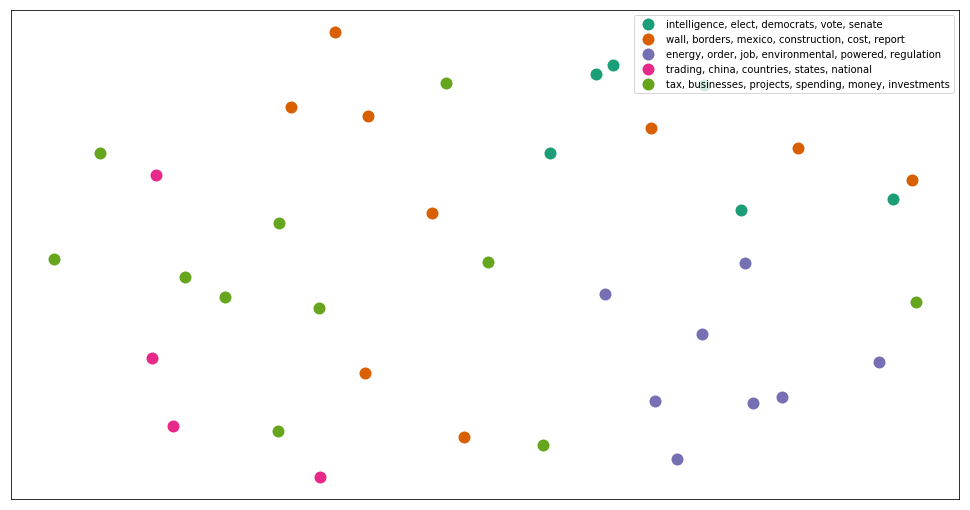

In [28]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

just_titles = clustering["Title"]
just_dsi = titles['DSI']

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=just_titles)) 
#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [15]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 300);
      this.fig.toolbar.toolbar.attr("y", 600);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [29]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=just_titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(15,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=13, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in str(group.title).decode('utf-8')]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0],
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

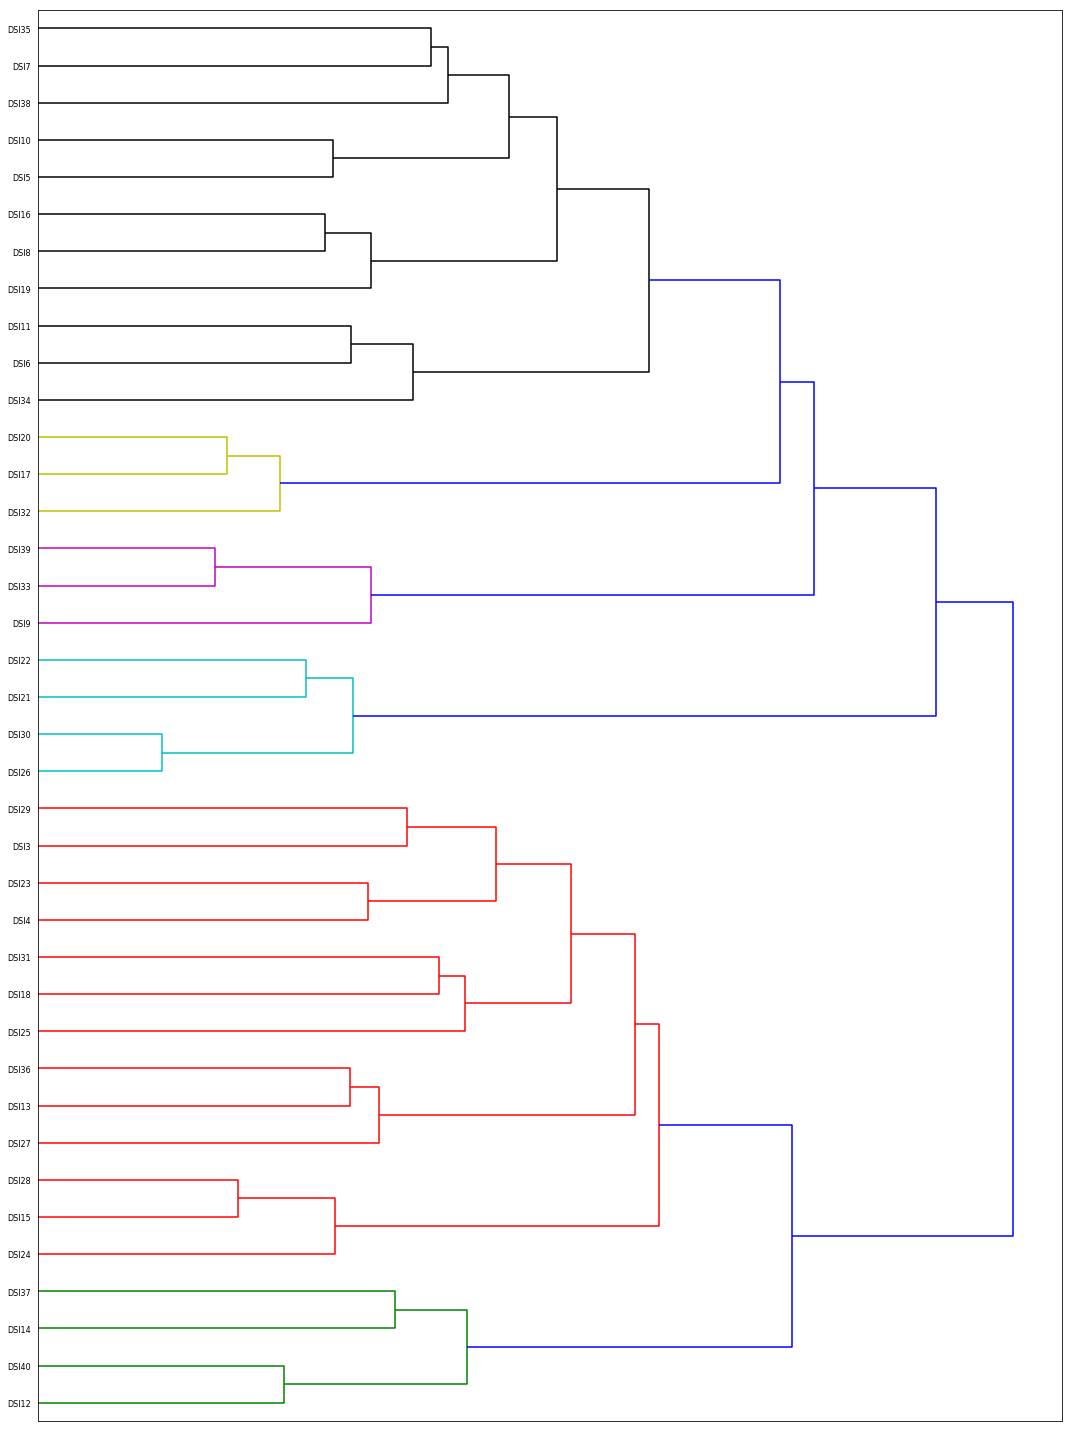

In [39]:
#Hierarchical Clustering
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=list(just_dsi));

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [40]:
#LDA
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [41]:
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns


In [46]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in all_docs]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in cachedStopWords] for text in tokenized_text]

CPU times: user 164 ms, sys: 7.16 ms, total: 171 ms
Wall time: 172 ms
CPU times: user 625 ms, sys: 22.6 ms, total: 647 ms
Wall time: 669 ms
CPU times: user 72.7 ms, sys: 645 µs, total: 73.3 ms
Wall time: 74.6 ms


In [47]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [50]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 1min 4s, sys: 1.14 s, total: 1min 5s
Wall time: 1min 10s


In [51]:
lda.show_topics()

[(0,
  u'0.014*"tax" + 0.013*"u" + 0.013*"countri" + 0.008*"secretari" + 0.008*"trade" + 0.007*"plan" + 0.007*"mr" + 0.007*"order" + 0.006*"mexico" + 0.006*"state"'),
 (1,
  u'0.010*"state" + 0.009*"energi" + 0.008*"china" + 0.007*"u" + 0.006*"new" + 0.005*"countri" + 0.005*"climat" + 0.005*"obama" + 0.005*"power" + 0.005*"like"'),
 (2,
  u'0.011*"elect" + 0.009*"russia" + 0.008*"intellig" + 0.007*"report" + 0.006*"us" + 0.006*"russian" + 0.005*"news" + 0.005*"one" + 0.004*"govern" + 0.004*"u"'),
 (3,
  u'0.015*"think" + 0.014*"vote" + 0.013*"mr" + 0.012*"spicer" + 0.011*"q" + 0.011*"go" + 0.008*"get" + 0.007*"member" + 0.006*"bill" + 0.006*"know"'),
 (4,
  u'0.013*"court" + 0.011*"senat" + 0.008*"democrat" + 0.008*"gorsuch" + 0.007*"republican" + 0.007*"countri" + 0.006*"conserv" + 0.006*"confirm" + 0.006*"suprem" + 0.005*"immigr"')]

In [95]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

topics_matrix = numpy.array(topics_matrix,dtype=object)

topics_matrix[1,1][1][0]

#topic_words = topics_matrix[:,:,1]
for i in range(0,4):
    print([topics_matrix[i,1][:5]])
    print()

[[(u'tax', 0.013589929498081023), (u'u', 0.013302817910391864), (u'countri', 0.012756490387442978), (u'secretari', 0.0083577713120300354), (u'trade', 0.0080861233518689218)]]

[[(u'state', 0.010073509285096174), (u'energi', 0.0086741511462710384), (u'china', 0.0084440788572707481), (u'u', 0.0067440403574450308), (u'new', 0.0056093893196342689)]]

[[(u'elect', 0.010556011479094681), (u'russia', 0.0094637458871564759), (u'intellig', 0.0083171482612185918), (u'report', 0.0066506962725489645), (u'us', 0.0063866471976599774)]]

[[(u'think', 0.0147709943153025), (u'vote', 0.01369499707623908), (u'mr', 0.01294844173570288), (u'spicer', 0.011613738631069551), (u'q', 0.011262200163956359)]]

